In [1]:
import glob
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage.filters
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
import sklearn.model_selection
import sklearn.metrics
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, Dropout
import keras.optimizers, keras.regularizers
from keras import backend as K
import keras.utils

import sdf.spectrum
from phot_funcs import *

%matplotlib notebook

Using TensorFlow backend.


# Machine learn IRS spectra

In [24]:
def spec2arr(f,norm=True):
    sp = sdf.spectrum.ObsSpectrum.read_cassis(f,module_split=True)
    if len(sp) < 4:
        return
    arr = np.array([])
    sn = np.array([])
    for s in sp:
        sn = np.append(sn,s.fnujy/s.e_fnujy)
        if norm:
            arr = np.append(arr,s.fnujy/np.mean(s.fnujy))
        else:
            arr = np.append(arr,s.fnujy)
            
    if len(arr) != 382:
        return
  
#     arr = scipy.ndimage.filters.median_filter(arr,size=5)
    
    return arr,sn

In [67]:
with open('irs_labels_cassis.txt','r') as f:
    data = json.load(f)

# labels = []
# for key in data.keys():
#     labels += data[key]
    
# label_names_found = np.unique(labels)
# label_names  = ['Class I','Class II','Transition','Kuiper','Exo-Zodi','Star',
#                 'Am Sil Em','Cryst Sil Em','PAH Em','Be Em','Gas Em',
#                 'Am Sil Abs','Ice Abs','Gas Abs',
#                 '[NeV]',
#                 'O-type','B-type','A-type','F-type','G-type','K-type','M-type','Brown Dwarf',
#                 'SL/LL offset']

# labels_keep = np.ones(len(label_names),dtype=bool)
# labels_keep[4] = False
# labels_keep[13] = False
# labels_keep[14] = False
# labels_keep[15] = False

# if len(label_names_found) != len(label_names):
#     print('Error, something wrong with labels')

files = []
spectra = []
sn = []
label_names = []
labels_onehot = []
# data_dir = '/Users/grant/a-extra/sdb/spectra/cassis/irsstare/'
data_dir = '/Users/grant/astro/projects/spec-ml/spectra/training/'
for i,file in enumerate(data.keys()):

    tmp = spec2arr(data_dir+file,norm=False)
    if tmp is None:
        print('Skipping {}'.format(file))
        continue
    else:
        tmp,tmp1 = tmp
        if np.mean(tmp1) < 20:
            continue

    spectra.append(tmp)
    sn.append(tmp1)
    files.append(file)
    
    for label in data[file]:
        if label not in label_names:
            label_names.append(label)
                         
for file in files:
    onehot_tmp = np.zeros(len(label_names))
    for label in data[file]:
        for i,lab in enumerate(label_names):
            if lab == label:
                onehot_tmp[i] = 1
    labels_onehot.append(onehot_tmp)
        
spectra = np.array(spectra)
sn = np.array(sn)
labels_onehot = np.array(labels_onehot)

# label_names = np.array(label_names)[labels_keep]
# labels_onehot = labels_onehot[:,labels_keep]

spec_len = spectra.shape[1]
nspec = spectra.shape[0]
nlabels = len(label_names)

for i in range(nlabels):
    print(np.sum(labels_onehot[:,i]),label_names[i])

if np.all(np.isfinite(spectra)):
    print('all finite')

Skipping cassis_yaaar_spcfw_20838656t.fits
Skipping cassis_yaaar_spcfw_4928768t.fits
Skipping cassis_yaaar_spcfw_16008960t.fits
Skipping cassis_yaaar_spcfw_16012288t.fits
Skipping cassis_yaaar_spcfw_21875712t.fits
Skipping cassis_yaaar_spcfw_22806016t.fits
Skipping cassis_yaaar_spcfw_18768128t.fits
Skipping cassis_yaaar_spcfw_18824704t.fits
Skipping cassis_yaaar_spcfw_18836992t.fits
Skipping cassis_yaaar_spcfw_20814336t.fits
Skipping cassis_yaaar_spcfw_20818432t.fits
Skipping cassis_yaaar_spcfw_20830464t.fits
106.0 Kuiper
39.0 F-type
152.0 Star
67.0 A-type
47.0 Class II
56.0 Am Sil Em
25.0 Class I
21.0 Am Sil Abs
20.0 Ice Abs
16.0 Cryst Sil Em
22.0 B-type
24.0 K-type
11.0 Exo-Zodi
36.0 G-type
8.0 Be Em
10.0 Gas Em
5.0 PAH Em
3.0 SL/LL offset
2.0 O-type
11.0 [NeV]
3.0 M-type
4.0 Transition
1.0 Brown Dwarf
all finite


<IPython.core.display.Javascript object>


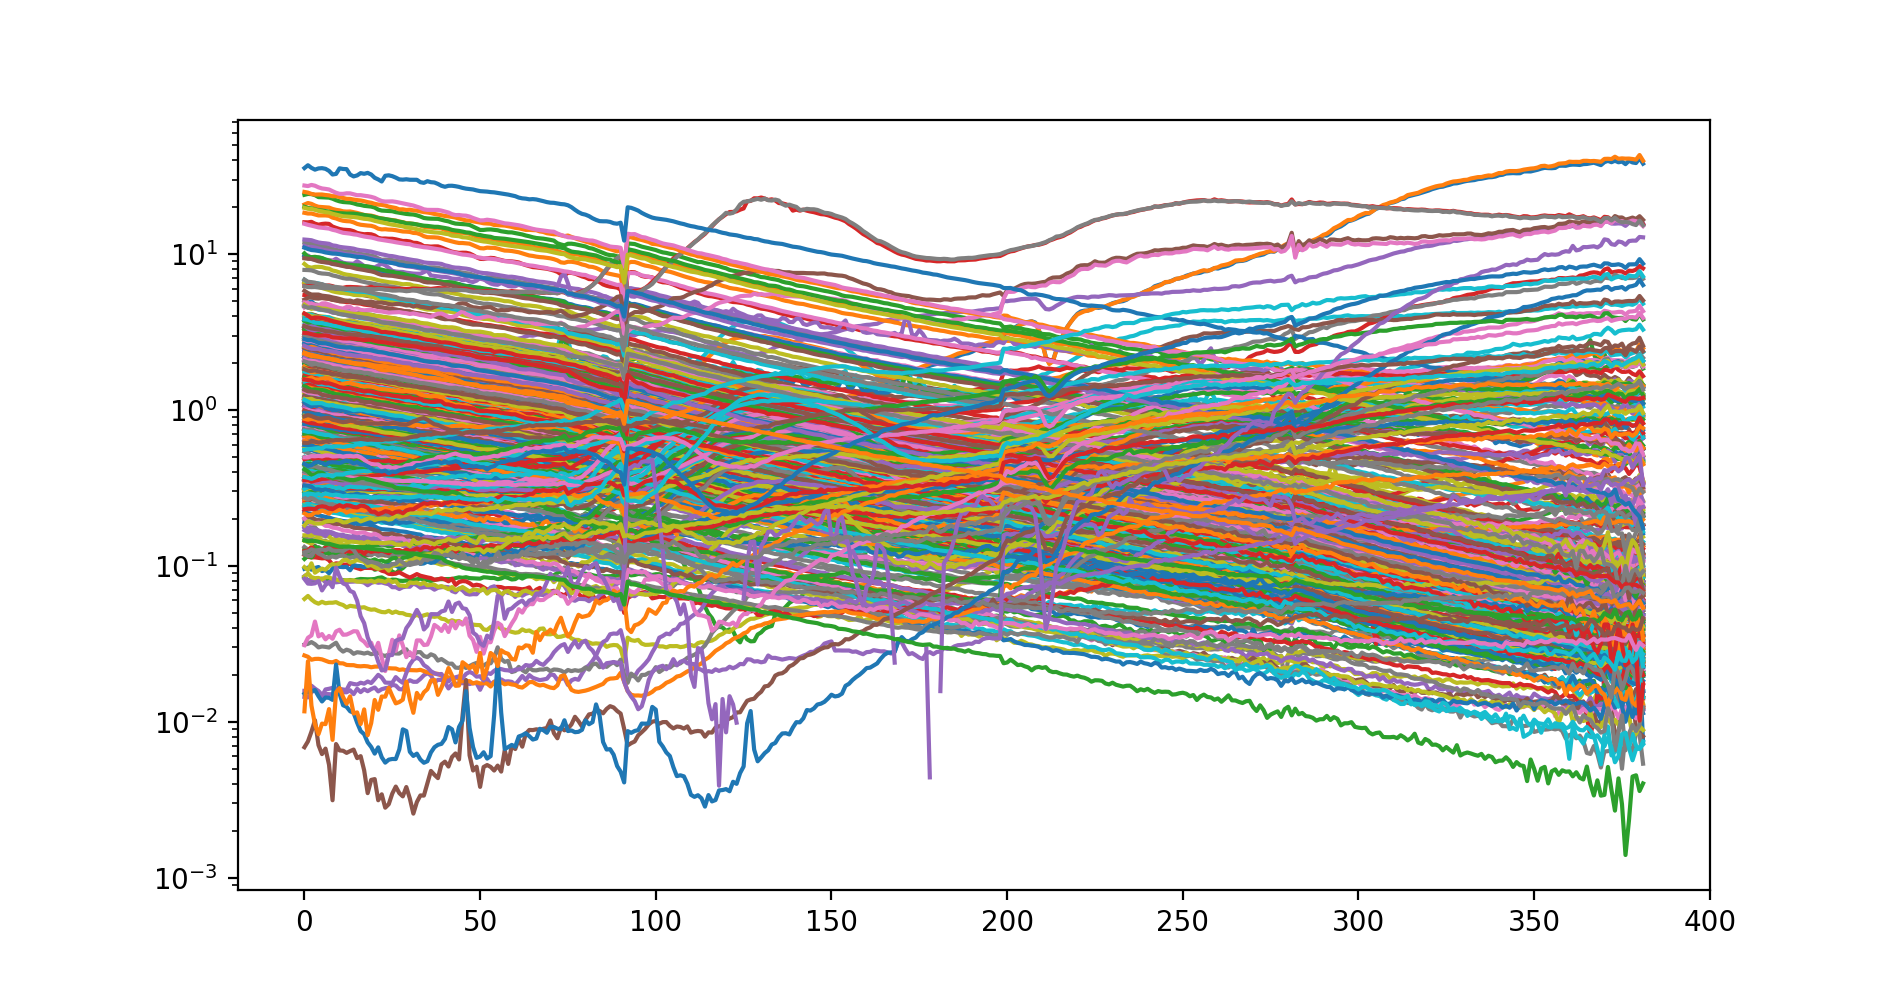

In [68]:
fig,ax = plt.subplots(figsize=(9.5,5))
l = ax.semilogy(spectra.T)

In [72]:
# split the data, simply by randomising
train_fraction = 0.7
n_train = int(nspec*train_fraction)
n_test = nspec - n_train
train_i = np.zeros(nspec,dtype=bool)
train_i[np.random.choice(nspec,n_train,replace=False)] = True
test_i = np.invert(train_i)

data_train = spectra[train_i]
labels_train = labels_onehot[train_i]
data_test = spectra[test_i]
labels_test = labels_onehot[test_i]

In [73]:
# this sets the defaults for things not varied in the grid search
if 0:
    clf = MLPClassifier(solver='lbfgs', alpha=0.001, hidden_layer_sizes=(10,20,10),
                       tol=1e-6, warm_start=False, max_iter=10000,
                        learning_rate_init=0.001, learning_rate='adaptive')

    grid = [#{'solver':['adam'], 'hidden_layer_sizes':[(20,40,20),(10,20,10)],
    #          'alpha':[1e-4,1e-2,0],'learning_rate_init':[0.001,0.01]},
    #          {'solver':['sgd'], 'hidden_layer_sizes':[(20,40,20),(10,20,10)],
    #           'alpha':[1e-6,1e-4,1e-2,0],'learning_rate_init':[0.001,0.01]},
            {'solver':['lbfgs'], 'hidden_layer_sizes':[(100,200,100),(40,80,40),(10,20,10)],
             'alpha':[1e-4,1e-2]}]
    gs = sklearn.model_selection.GridSearchCV(clf,grid,cv=4)
    gs.fit(data_train,labels_train)

    print("Best parameters found on training set:")
    print(gs.best_params_)
    print()
    print("Grid scores on training set:")
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

In [74]:
clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(100,200,100),
                   tol=1e-6, warm_start=False, max_iter=50000,
                    learning_rate_init=0.001, learning_rate='adaptive')

clf.fit(data_train,labels_train)
print('Step',clf.n_iter_,'loss',clf.loss_)

KeyboardInterrupt: 

In [75]:
if 0:
    fig,ax = plt.subplots(figsize=(9.5,5))

    # run for all
    s = sklearn.model_selection.cross_val_score(clf,spectra,labels_onehot,cv=4,verbose=0)
    print('Cross validation:',s)

    # and at different numbers
    sz,train_score,test_score = sklearn.model_selection.learning_curve(clf,data_train,labels_train,
                                                                      train_sizes=np.linspace(0.1,1,5),cv=4)
    ax.plot(sz,train_score,':')
    ax.plot(sz,test_score)

In [76]:
# classification report using test set
true, pred = labels_test, clf.predict(data_test)
print(sklearn.metrics.classification_report(true, pred,target_names=label_names))

              precision    recall  f1-score   support

      Kuiper       0.91      0.91      0.91        33
      F-type       0.00      0.00      0.00        11
        Star       0.94      1.00      0.97        44
      A-type       0.56      0.71      0.63        21
    Class II       0.86      0.92      0.89        13
   Am Sil Em       1.00      0.84      0.91        19
     Class I       0.88      1.00      0.93         7
  Am Sil Abs       0.83      0.71      0.77         7
     Ice Abs       0.57      0.80      0.67         5
Cryst Sil Em       0.50      0.17      0.25         6
      B-type       0.00      0.00      0.00         9
      K-type       0.67      0.29      0.40         7
    Exo-Zodi       1.00      0.40      0.57         5
      G-type       0.80      0.31      0.44        13
       Be Em       1.00      1.00      1.00         2
      Gas Em       0.67      1.00      0.80         2
      PAH Em       0.50      1.00      0.67         1
SL/LL offset       0.00    

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [77]:
# make a "confusion" matrix. columns are predicted labels, row are true
# for each incorrect predicted label, every true label that exists for a spectrum
# is given +1
def cm(true,pred):
    cm = np.zeros((nlabels,nlabels))
    for i,p_list in enumerate(pred):
        t_list = true[i]

        for k,p in enumerate(p_list):
            if p == 1:
                if t_list[k] == 1: # skip correct labels
                    continue
                for l,t in enumerate(t_list):
                    if t == 1:
                        cm[l,k] += 1

    fig,ax = plt.subplots(figsize=(9.5,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    for n in [4.5,11.5,18.5]:
        ax.plot(ax.get_xlim(),[n,n],color='grey')
        ax.plot([n,n],ax.get_ylim(),color='grey')

    fig.colorbar(im)

    tick_marks = np.arange(len(label_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels( label_names, rotation=90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels( label_names)

<IPython.core.display.Javascript object>


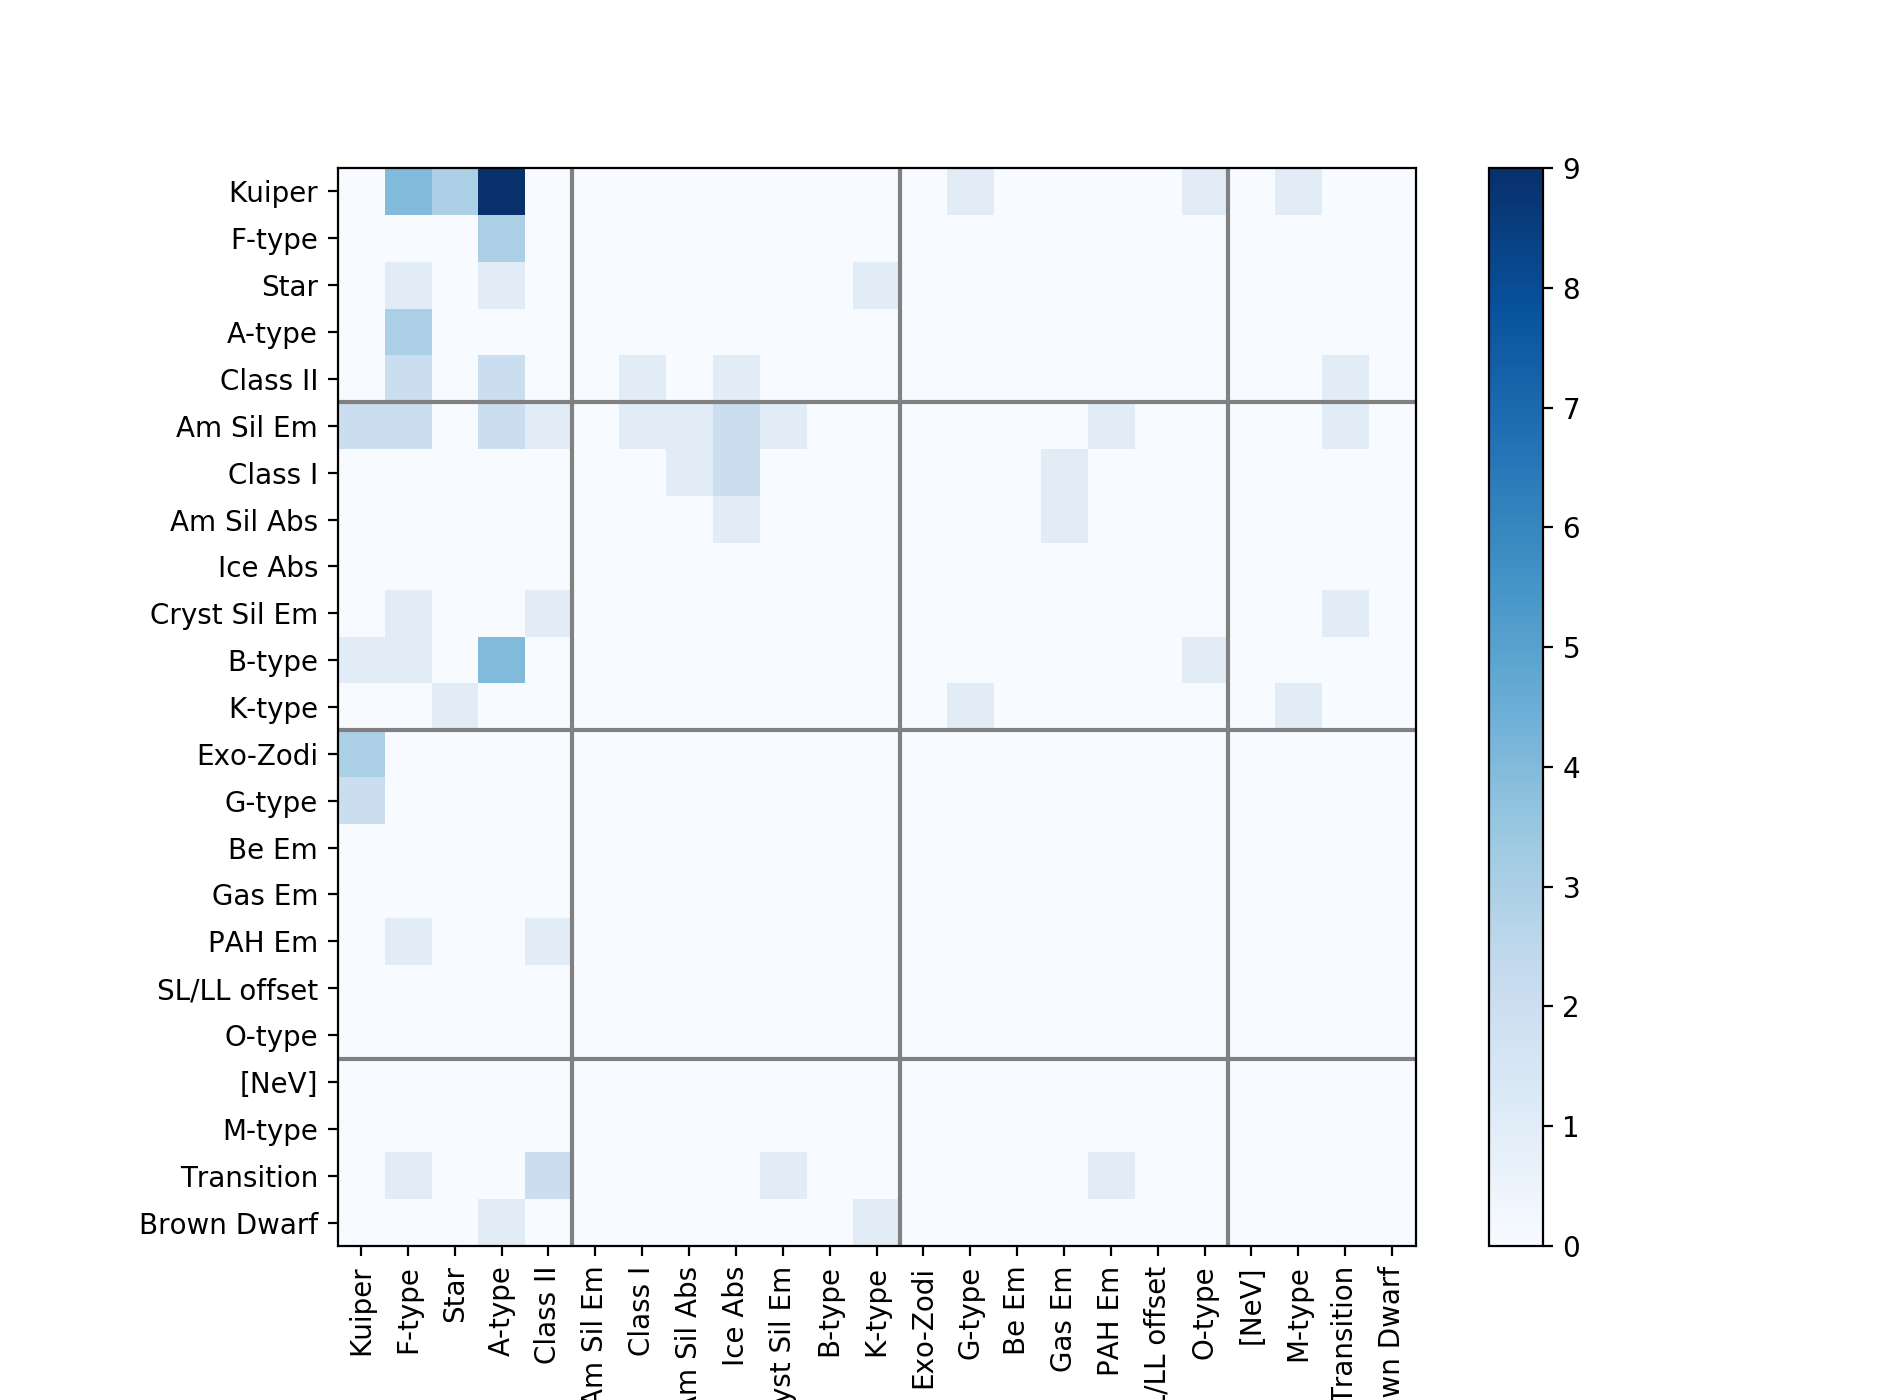

In [78]:
cm(true,pred)

In [79]:
# save the model
with open('irs-nn-classifier.pkl','wb') as f:
    pickle.dump(label_names,f)
    pickle.dump(clf,f)

# test the model

Now test the model against some other spectra, see what it thinks they are, and see if we agree. First the test set, and then some random spectra

<IPython.core.display.Javascript object>


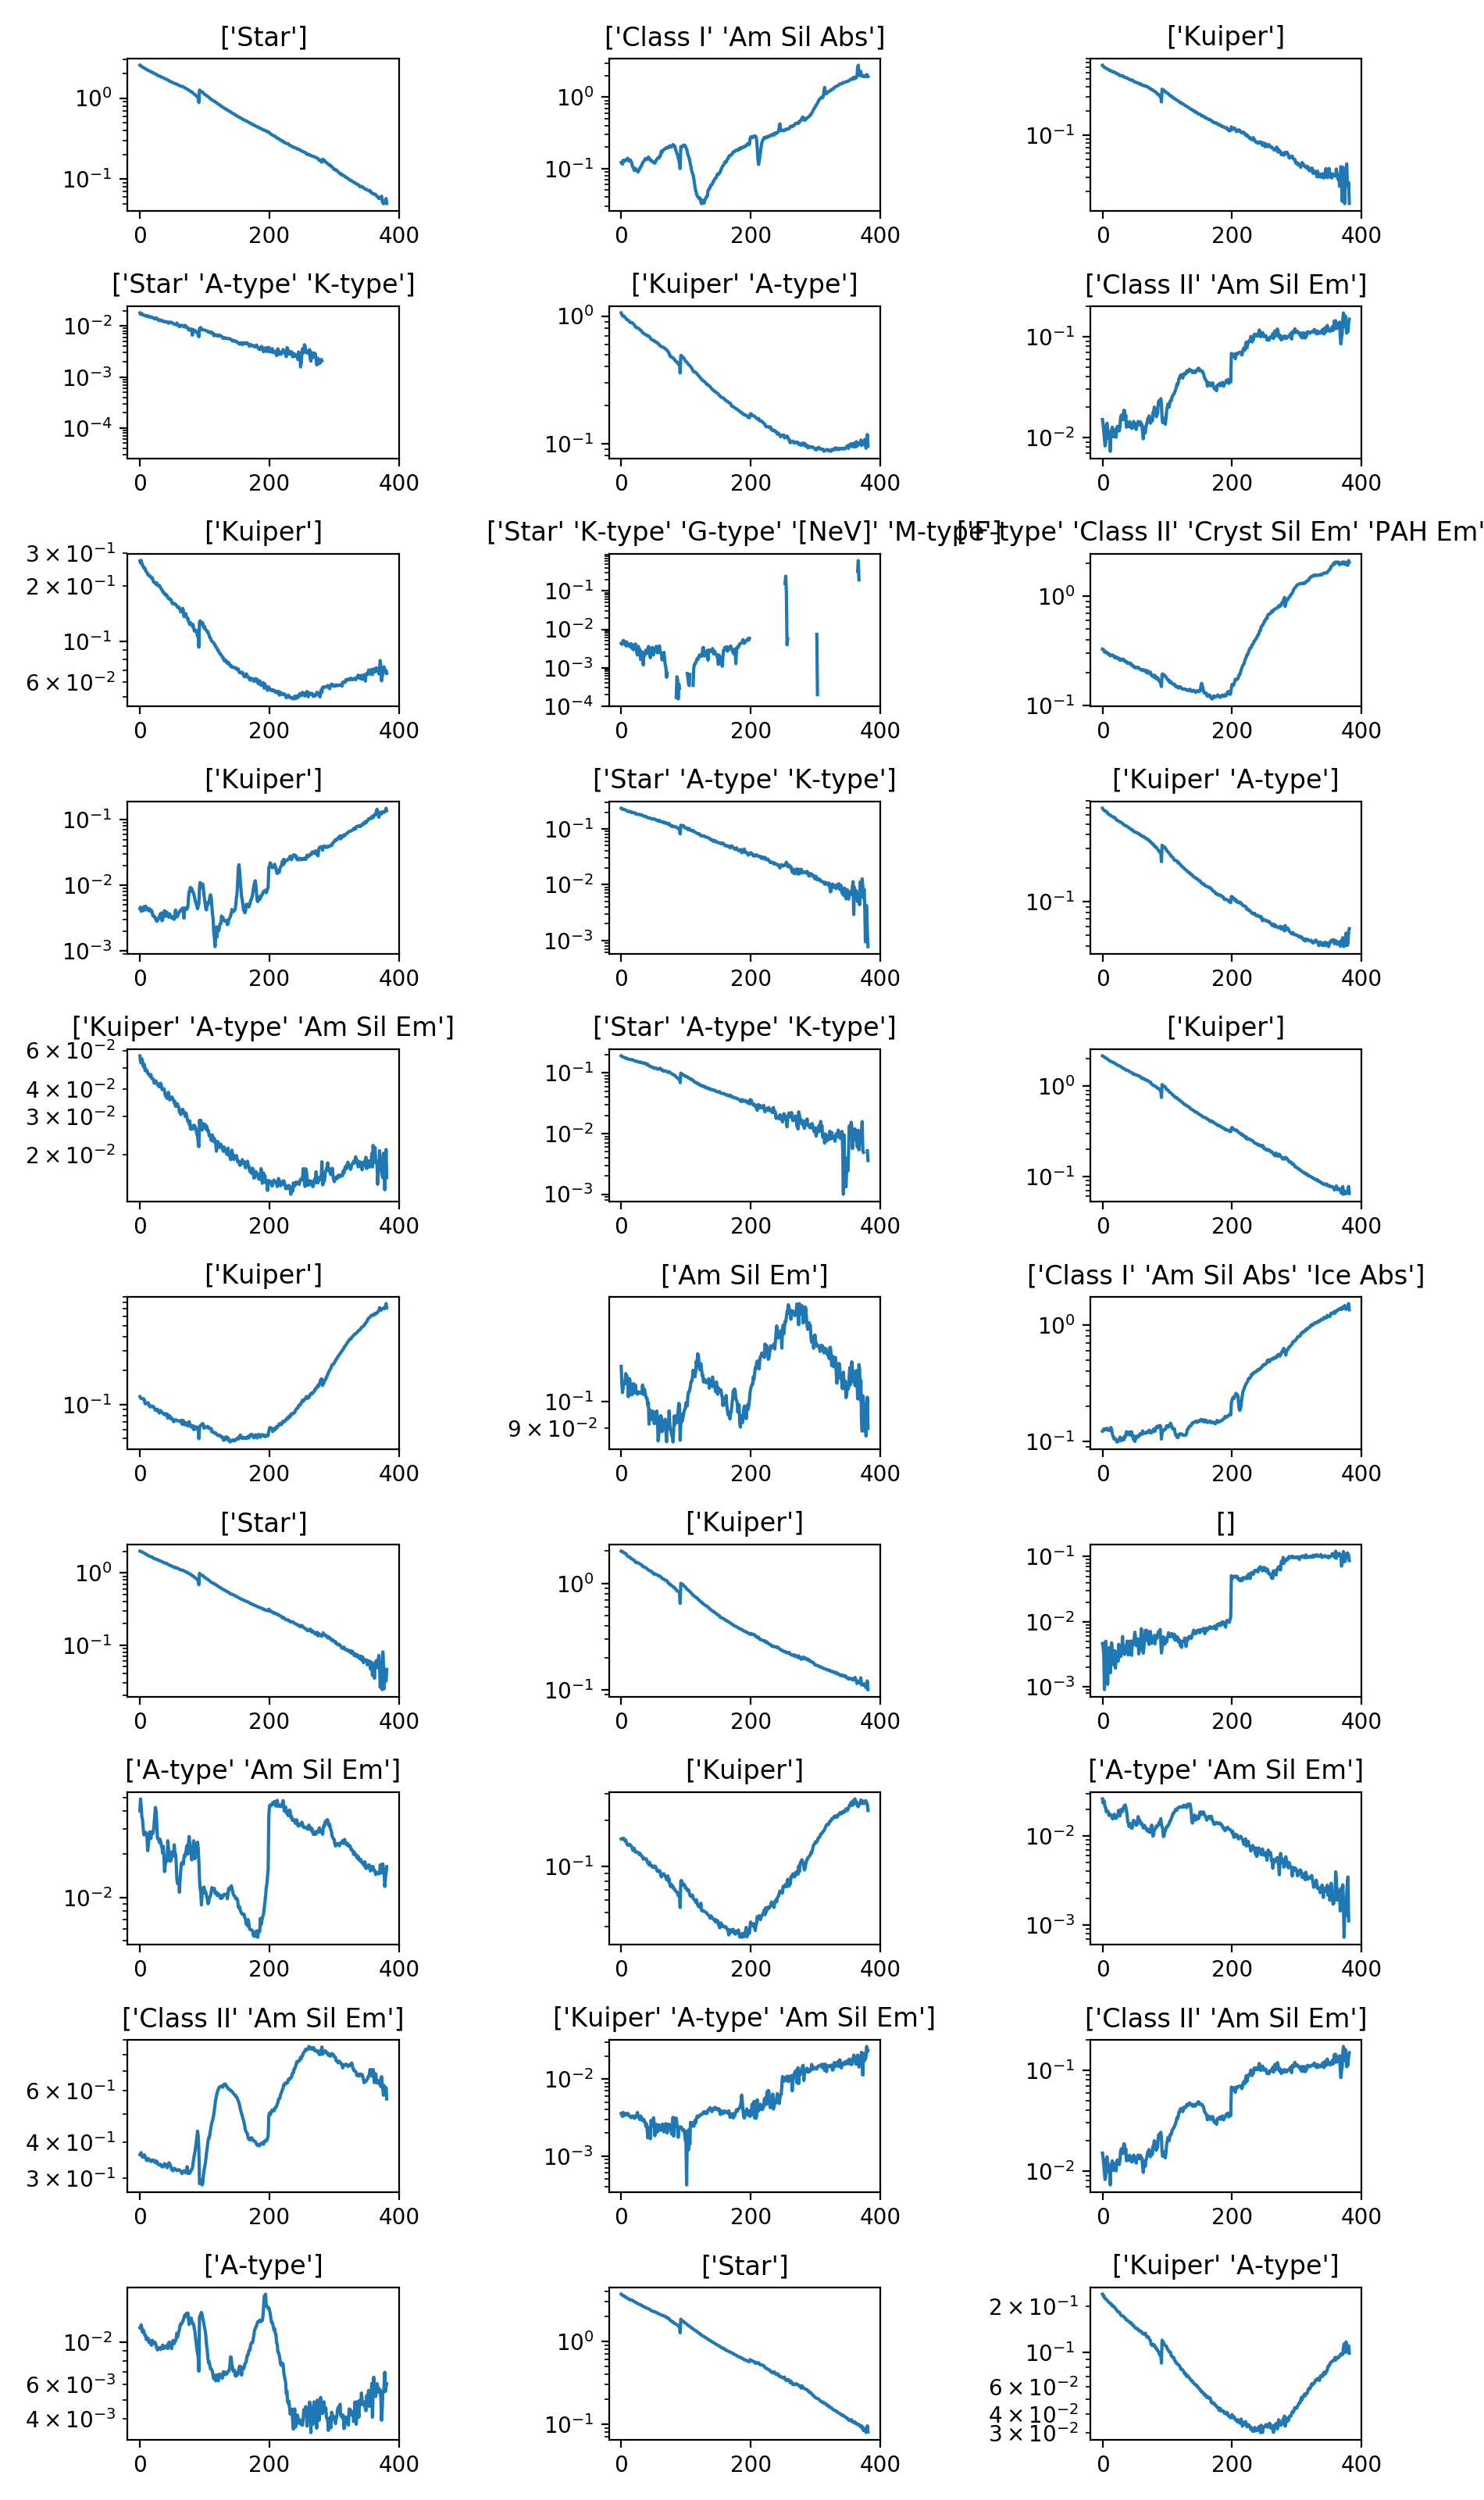

In [82]:
fs = glob.glob('/Users/grant/astro/projects/spec-ml/spectra/irsstare/*.fits')
spec_grid = (10,3)
nspec = spec_grid[0] * spec_grid[1]
fig,ax = plt.subplots(spec_grid[0],spec_grid[1],figsize=(9.5,16))
i = 0
while i < nspec:
    j = np.random.randint(len(fs))
    spec = spec2arr(fs[j],norm=False)
    spec_norm = spec2arr(fs[j])
    if spec is None:
        continue
    else:
        spec,sn = spec
    axi = np.unravel_index(i,spec_grid)
    ax[axi].semilogy(spec)
    pred = clf.predict(spec.reshape(1,-1))
    ax[axi].set_title(np.array(label_names)[np.where(pred[0])[0]])
    i += 1
    
fig.tight_layout()

# Keras version

In [83]:
model = Sequential()

# model.add(Dense(100, input_dim=spec_len))
# model.add(Activation('relu'))

model.add(Conv1D(10,30,strides=5,input_shape=(spec_len,1)))
model.add(Activation('relu'))
model.add(Flatten())

model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dense(nlabels))
model.add(Activation('sigmoid'))

def loss(y_true, y_pred):
    '''Binary log loss, from sklearn/neural_network/_base.py'''
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=True)
opt = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])

data_in = data_train.reshape(data_train.shape[0],data_train.shape[1],1)
model.fit(data_in, labels_train, epochs=5000, batch_size=50)

Epoch 1/5000
247/247 [==============================] - 0s - loss: 0.5389 - acc: 0.0000e+00     
Epoch 2/5000
247/247 [==============================] - 0s - loss: 0.3471 - acc: 0.3401         
Epoch 3/5000
247/247 [==============================] - 0s - loss: 0.2736 - acc: 0.3806     
Epoch 4/5000
247/247 [==============================] - 0s - loss: 0.2382 - acc: 0.3522         
Epoch 5/5000
247/247 [==============================] - 0s - loss: 0.2185 - acc: 0.4818     
Epoch 6/5000
247/247 [===============

In [84]:
# tmp = model.predict(data_test)
tmp = model.predict(data_test.reshape(data_test.shape[0],data_test.shape[1],1))
pred = np.zeros(tmp.shape)
pred[tmp>0.5] = 1 
print(sklearn.metrics.classification_report(labels_test, pred, target_names=label_names))

              precision    recall  f1-score   support

      Kuiper       0.88      0.85      0.86        33
      F-type       0.12      0.09      0.11        11
        Star       0.93      0.91      0.92        44
      A-type       0.67      0.57      0.62        21
    Class II       0.93      1.00      0.96        13
   Am Sil Em       0.89      0.89      0.89        19
     Class I       1.00      0.86      0.92         7
  Am Sil Abs       1.00      0.57      0.73         7
     Ice Abs       0.71      1.00      0.83         5
Cryst Sil Em       0.75      0.50      0.60         6
      B-type       0.40      0.22      0.29         9
      K-type       0.33      0.14      0.20         7
    Exo-Zodi       1.00      0.80      0.89         5
      G-type       0.33      0.38      0.36        13
       Be Em       1.00      1.00      1.00         2
      Gas Em       1.00      1.00      1.00         2
      PAH Em       0.50      1.00      0.67         1
SL/LL offset       0.00    

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<IPython.core.display.Javascript object>


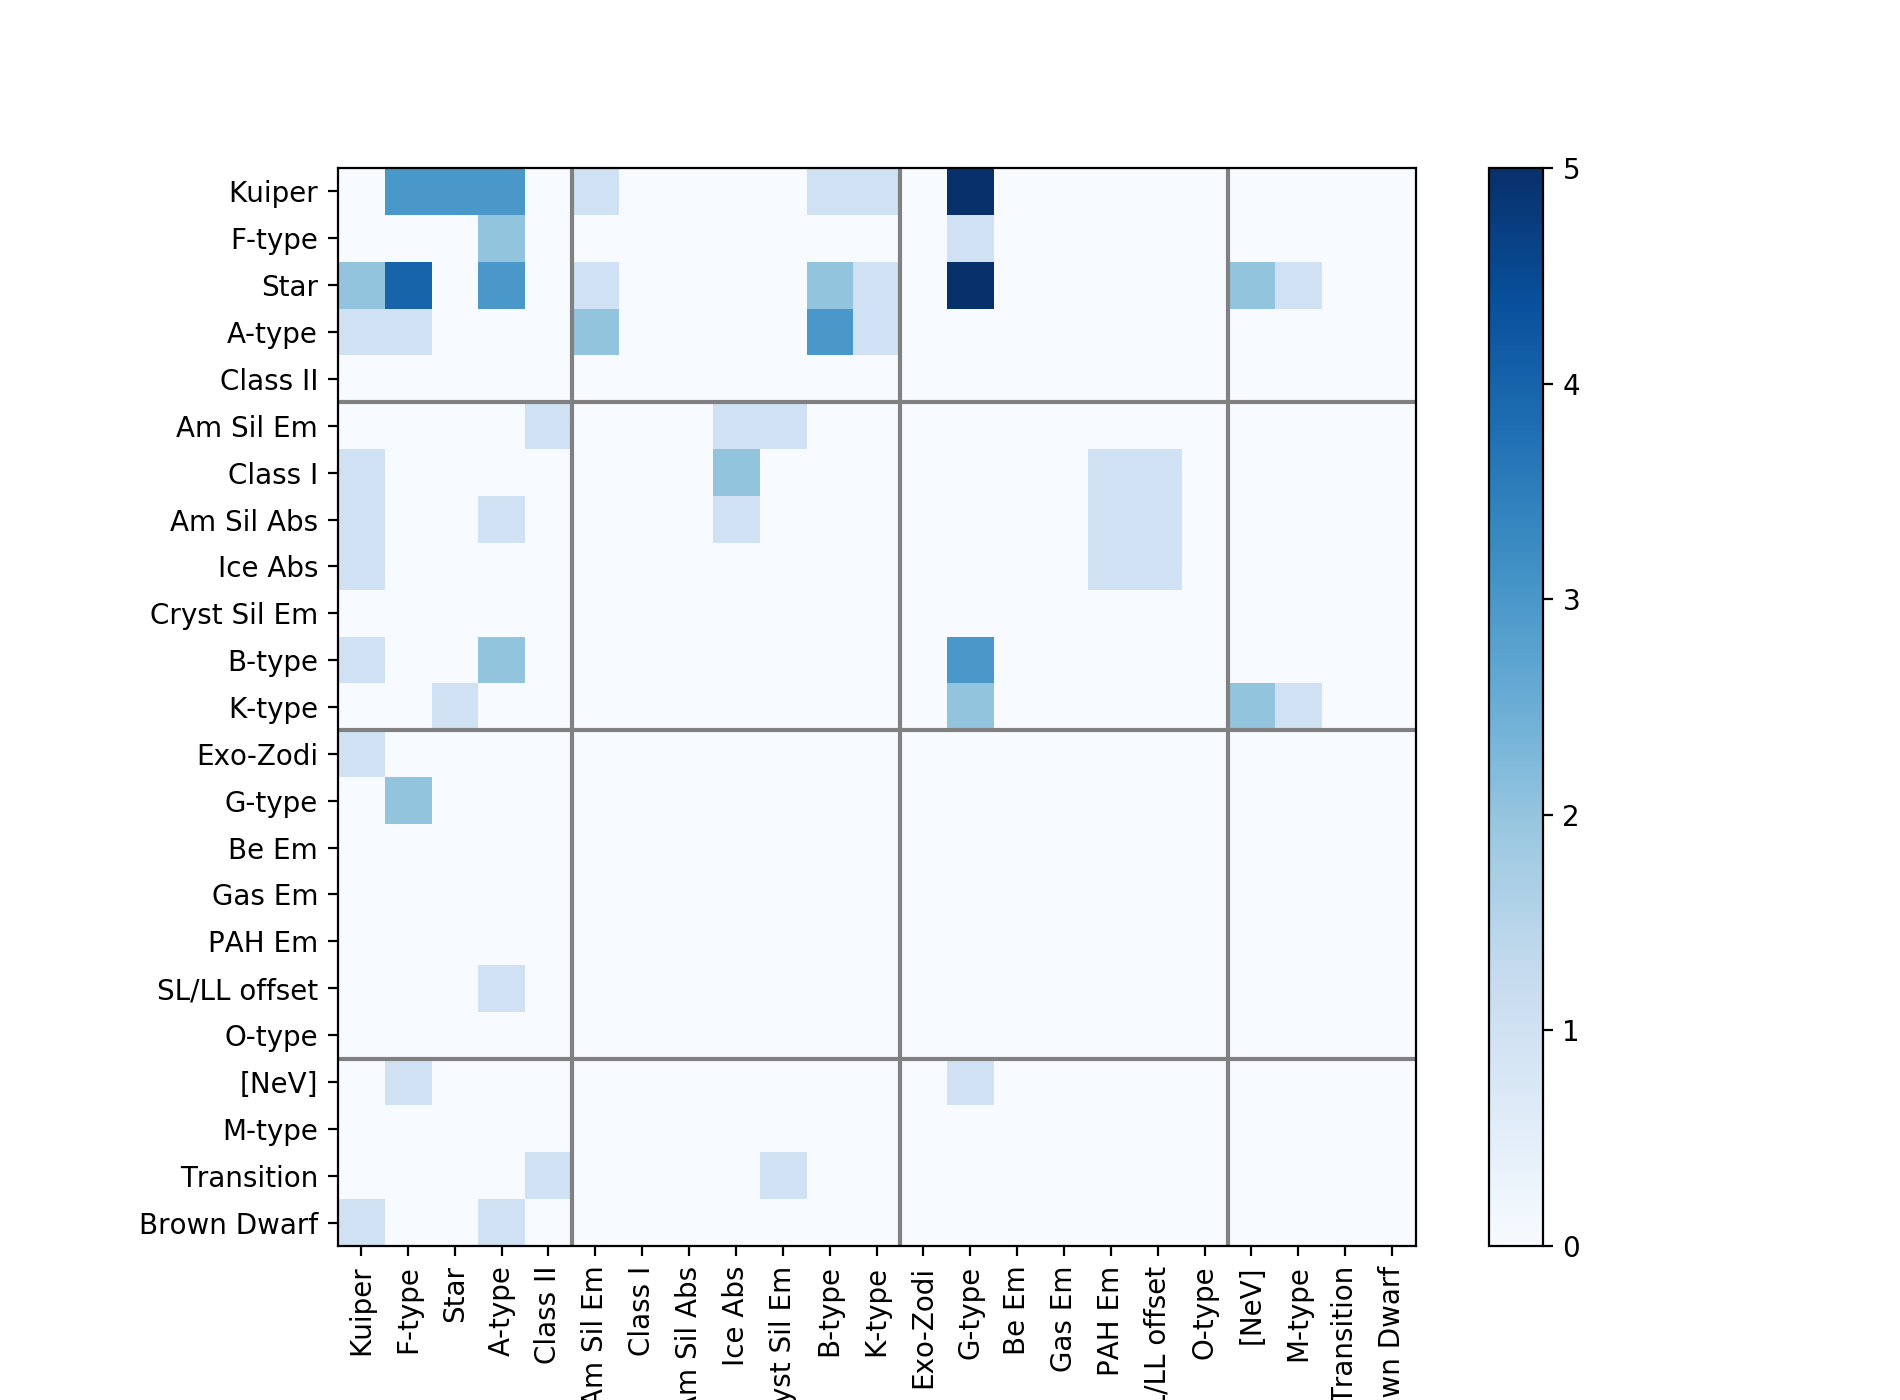

In [85]:
cm(labels_test,pred)

<IPython.core.display.Javascript object>


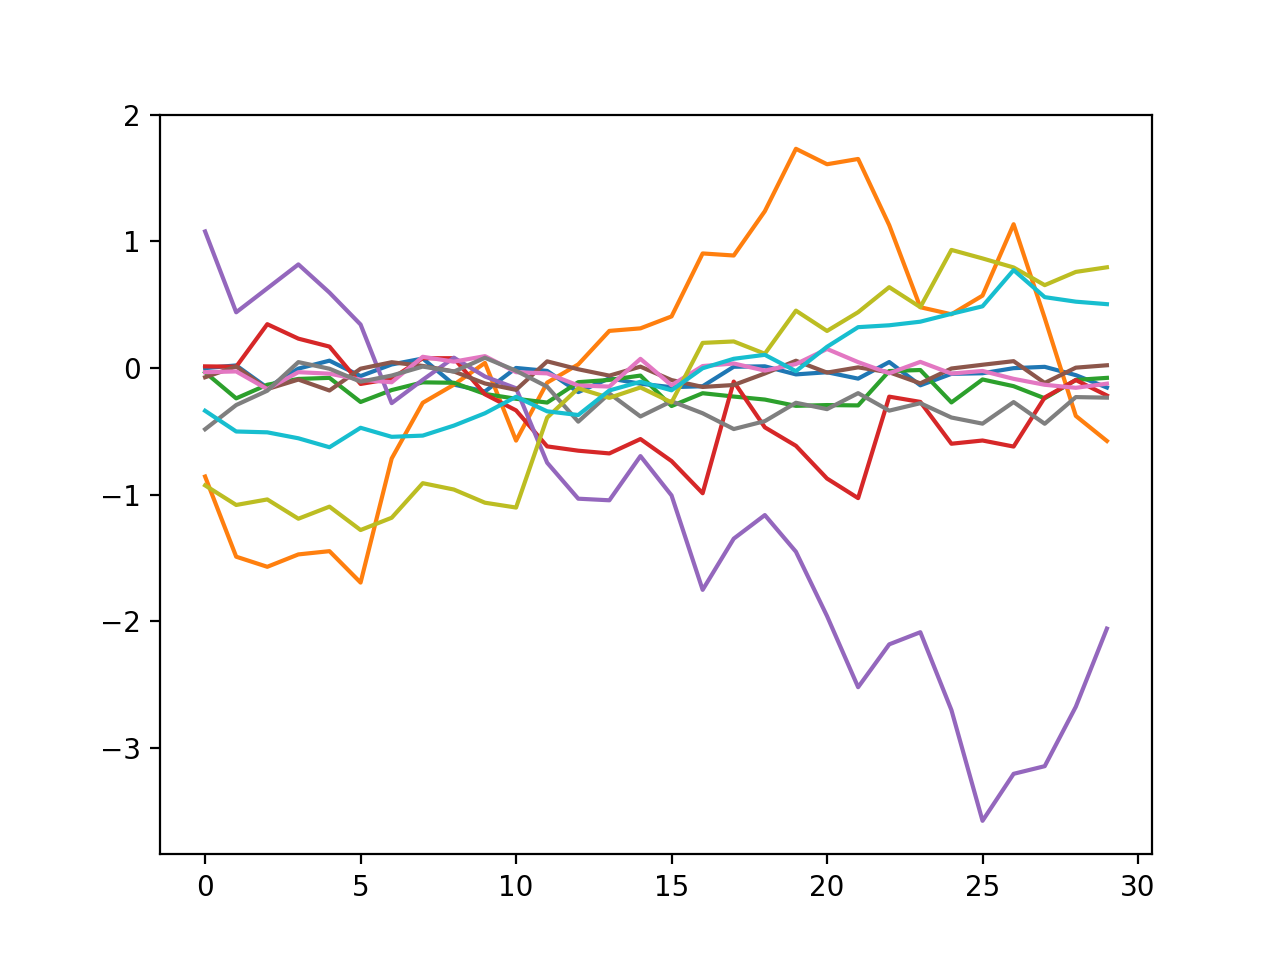

In [86]:
l = model.get_layer(index=1).get_weights()
fig,ax = plt.subplots()
ax.plot(l[0][:,0,:])